# Problem statement


<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## LSTM on Donor choose dataset

In [ ]:
#!gdown --id 1GpATd_pM4mcnWWIs28-s1lgqdAg2Wdv-
#!gdown --id 1pGd5tLwA30M7wkbJKdXHaae9tYVDICJ_

In [ ]:
#importing all the required lib
import pandas as pd
import numpy as np 
import os
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import SpatialDropout1D, LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape,LSTM
from keras.models import Sequential
from keras.layers import LeakyReLU
from keras import Model,Input
from keras import regularizers
from keras.layers.convolutional import Conv2D,Conv1D
import keras.backend as k
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import keras
from sklearn.utils import compute_class_weight
from keras.initializers import he_normal,glorot_normal
from keras.regularizers import l1,l2
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from IPython.display import SVG, display
import pickle 
import warnings
warnings.filterwarnings("ignore")
import datetime
tf.compat.v1.disable_eager_execution()
#from tensorflow.python.keras.layers import CuDNNLSTM


# Loading data

In [ ]:
# mounted my Google Drive in colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check ls command
!ls "/content/drive/My Drive/lstm donor choose"

'Copy of 1_Reference_EDA.ipynb'		   'Copy of preprocessed_data.csv'
'Copy of 2_Reference_Preprocessing.ipynb'  'Copy of tensorboard.ipynb'
'Copy of glove_vectors'			    lstm_output


In [ ]:
# load pre-processed file
project_data = pd.read_csv('/content/drive/My Drive/lstm donor choose/Copy of preprocessed_data.csv')
project_data.shape

(109248, 9)

In [ ]:
project_data

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74
...,...,...,...,...,...,...,...,...,...
109243,hi,mrs,grades_9_12,5,1,health_sports,teamsports,our day starts 100 students athletes low incom...,143.36
109244,nm,ms,grades_prek_2,3,1,appliedlearning,earlydevelopment other,my students range age four five years old atte...,268.57
109245,il,mrs,grades_3_5,0,1,math_science,appliedsciences environmentalscience,we title 1 school 650 total students our eleme...,399.00
109246,hi,mrs,grades_9_12,1,1,math_science,health_lifescience,i teach many different types students my class...,287.73


In [ ]:
# identify distinct values in school_state
print(project_data['school_state'].describe())
print(project_data['school_state'].unique())

count     109248
unique        51
top           ca
freq       15388
Name: school_state, dtype: object
['ca' 'ut' 'ga' 'wa' 'hi' 'il' 'oh' 'ky' 'sc' 'fl' 'mo' 'mi' 'ny' 'va'
 'md' 'tx' 'ms' 'nj' 'az' 'ok' 'pa' 'wv' 'nc' 'co' 'dc' 'ma' 'id' 'al'
 'me' 'tn' 'in' 'la' 'ct' 'ar' 'ks' 'or' 'wi' 'ia' 'sd' 'ak' 'mn' 'nm'
 'nv' 'mt' 'ri' 'nh' 'wy' 'ne' 'de' 'nd' 'vt']


In [ ]:
# identify distinct values in project_grade_category
print(project_data['project_grade_category'].describe())
print(project_data['project_grade_category'].unique())

count            109248
unique                4
top       grades_prek_2
freq              44225
Name: project_grade_category, dtype: object
['grades_prek_2' 'grades_3_5' 'grades_9_12' 'grades_6_8']


In [ ]:
# identify distinct values in clean_categories
print(project_data['clean_categories'].describe())
print(project_data['clean_categories'].unique())

count                109248
unique                   51
top       literacy_language
freq                  23655
Name: clean_categories, dtype: object
['math_science' 'specialneeds' 'literacy_language' 'appliedlearning'
 'math_science history_civics' 'literacy_language math_science'
 'appliedlearning music_arts' 'math_science appliedlearning'
 'math_science literacy_language' 'history_civics literacy_language'
 'appliedlearning health_sports' 'math_science music_arts'
 'appliedlearning literacy_language' 'music_arts' 'health_sports'
 'literacy_language specialneeds' 'math_science specialneeds'
 'appliedlearning history_civics' 'appliedlearning specialneeds'
 'health_sports literacy_language' 'literacy_language music_arts'
 'history_civics math_science' 'specialneeds health_sports'
 'literacy_language history_civics' 'health_sports specialneeds'
 'history_civics music_arts' 'math_science health_sports'
 'music_arts specialneeds' 'specialneeds music_arts'
 'health_sports history_civics' '

In [ ]:
# identify distinct values in clean_subcategories
print(project_data['clean_subcategories'].describe())
print(project_data['clean_subcategories'].unique())

count       109248
unique         401
top       literacy
freq          9486
Name: clean_subcategories, dtype: object
['appliedsciences health_lifescience' 'specialneeds' 'literacy'
 'earlydevelopment' 'mathematics socialsciences' 'literacy mathematics'
 'appliedsciences history_geography' 'esl literacy'
 'appliedsciences mathematics' 'extracurricular visualarts'
 'appliedsciences earlydevelopment' 'environmentalscience literacy'
 'appliedsciences environmentalscience'
 'history_geography literature_writing' 'literacy literature_writing'
 'earlydevelopment gym_fitness' 'environmentalscience visualarts'
 'environmentalscience mathematics' 'appliedsciences visualarts'
 'earlydevelopment literacy' 'music' 'teamsports'
 'health_lifescience mathematics' 'music performingarts'
 'esl environmentalscience' 'college_careerprep esl'
 'appliedsciences other' 'college_careerprep visualarts'
 'literature_writing specialneeds' 'health_lifescience specialneeds'
 'environmentalscience literature_writin

In [ ]:
# identify distinct values in teacher_prefix
project_data['teacher_prefix'].describe()
project_data['teacher_prefix'].values

array(['mrs', 'ms', 'mrs', ..., 'mrs', 'mrs', 'mrs'], dtype=object)

In [ ]:
# droping class label data
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
X = project_data
project_data.shape

(109248, 8)

In [ ]:
# Split Train, CV and Test data (64, 16, 20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

print('Train Data Set', X_train.shape, y_train.shape)
print('Cross Validate Data Set', X_cv.shape, y_cv.shape)
print('Test Data Set', X_test.shape, y_test.shape)

Train Data Set (69918, 8) (69918,)
Cross Validate Data Set (17480, 8) (17480,)
Test Data Set (21850, 8) (21850,)


# Encoding, padding and vectorizing text data

In [ ]:
#for sequence lenth calculation
max_length = 0
seq_len=[]
for text in X_train['essay']:
  length = len(text.split())
  seq_len.append(length)
  if length > max_length:
    max_length = length

95th percentile of seq_len :  231.0


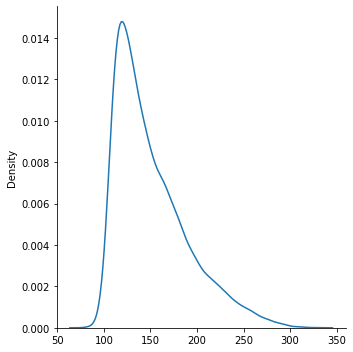

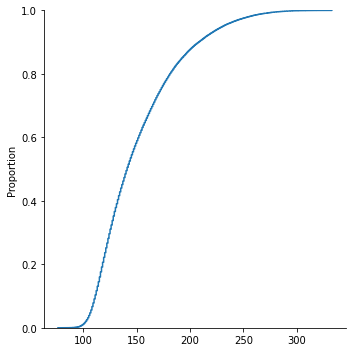

In [ ]:
import seaborn as sns
sns.displot(data=seq_len, kind="kde")
sns.displot(data=seq_len, kind="ecdf")
print("95th percentile of seq_len : ",np.percentile(seq_len, 95))

In [ ]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
def padded(encoded_docs):  
  seq_length = 250  #we have choosen which is more lenght than 95 percentile the sentence length
  padded_docs = pad_sequences(encoded_docs, maxlen=seq_length, padding='post')
  return padded_docs

In [ ]:
#https://stackoverflow.com/posts/51956230/revisions
t = Tokenizer()
t.fit_on_texts(X_train['essay'])
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_train['essay'])
X_train_essay = padded(encoded_docs)

In [ ]:
print(encoded_docs[1])
print("before padding length",len(encoded_docs[1]))

[4, 1, 22, 385, 332, 140, 5, 59, 197, 1, 19, 72, 39, 19, 5, 31, 111, 4, 1, 22, 6, 211, 12, 51, 59, 2, 34, 21, 488, 44, 75, 174, 10, 25, 6, 3, 1609, 220, 5, 585, 825, 1549, 880, 776, 56, 36, 365, 11, 371, 269, 26, 790, 368, 72, 39, 38, 235, 94, 668, 331, 5, 25, 3, 66, 285, 407, 340, 43, 1, 656, 91, 38, 235, 24, 71, 535, 1, 66, 340, 4, 1, 21, 18, 235, 17, 41, 668, 761, 617, 310, 66, 1523, 589, 439, 2518, 5, 1374, 432, 28, 66, 43, 1, 535, 137, 589, 2486, 2277, 466, 11, 33, 5, 80, 13]
before padding length 113


In [ ]:
print(X_train_essay[1])
print("after padding length",len(X_train_essay[1]))

[   4    1   22  385  332  140    5   59  197    1   19   72   39   19
    5   31  111    4    1   22    6  211   12   51   59    2   34   21
  488   44   75  174   10   25    6    3 1609  220    5  585  825 1549
  880  776   56   36  365   11  371  269   26  790  368   72   39   38
  235   94  668  331    5   25    3   66  285  407  340   43    1  656
   91   38  235   24   71  535    1   66  340    4    1   21   18  235
   17   41  668  761  617  310   66 1523  589  439 2518    5 1374  432
   28   66   43    1  535  137  589 2486 2277  466   11   33    5   80
   13    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
encoded_docs = t.texts_to_sequences(X_cv['essay'])
X_cv_essay = padded(encoded_docs)

In [ ]:
encoded_docs = t.texts_to_sequences(X_test['essay'])
X_test_essay = padded(encoded_docs)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip   #downloading glove vectors

--2022-12-24 10:50:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-24 10:50:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-24 10:50:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

In [ ]:
embeddings_index = dict()
f = open('/content/glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
print("embedding matrix shape",embedding_matrix.shape)

embedding matrix shape (47421, 300)


In [ ]:
"""# build logic to tokenize input
# Steps below
# 1. Count frequencies of each word
# 2. Sort frequencies by desc order
# 3. Assign rank to frequencies
# 4. Tokenize words in the main categorical variable
sent_list = [
    'The phone is very fast',
    'The phone is not bad',
    'I have good phone',
]

# count no. of words and assign it to dictionary
words_dict = {}
for sent in sent_list:
    words = sent.split()
    for i in words:
        if(i in words_dict):
            words_dict[i] += 1
        else:
            words_dict[i] = 1
            
print(words_dict)
print('*'*100)

# sort dictionary by their frequencies
sorted_dict = sorted(words_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_dict)
print('*'*100)


# assign rank to each word
rank = 1
final_dict = {} 
for item in sorted_dict:
    item = list(item)
    final_dict[item[0]] = rank
    rank += 1
    
print(final_dict)
print('*'*100)

# finally convert main sentences into tokens
tokenize_list = []
for sent in sent_list:
    words = sent.split()
    tokenize_sublist = []
    for item in words:
        if(item in final_dict):
            tokenize_sublist.append(final_dict[item])
    
    tokenize_list.append(tokenize_sublist)
        
print(tokenize_list)
print('*'*100)"""

"# build logic to tokenize input\n# Steps below\n# 1. Count frequencies of each word\n# 2. Sort frequencies by desc order\n# 3. Assign rank to frequencies\n# 4. Tokenize words in the main categorical variable\nsent_list = [\n    'The phone is very fast',\n    'The phone is not bad',\n    'I have good phone',\n]\n\n# count no. of words and assign it to dictionary\nwords_dict = {}\nfor sent in sent_list:\n    words = sent.split()\n    for i in words:\n        if(i in words_dict):\n            words_dict[i] += 1\n        else:\n            words_dict[i] = 1\n            \nprint(words_dict)\nprint('*'*100)\n\n# sort dictionary by their frequencies\nsorted_dict = sorted(words_dict.items(), key=lambda x: x[1], reverse=True)\nprint(sorted_dict)\nprint('*'*100)\n\n\n# assign rank to each word\nrank = 1\nfinal_dict = {} \nfor item in sorted_dict:\n    item = list(item)\n    final_dict[item[0]] = rank\n    rank += 1\n    \nprint(final_dict)\nprint('*'*100)\n\n# finally convert main sentences int

# Encoding categorical features

In [ ]:
def fit_transform_train_data(train_data):
    bag_of_words = CountVectorizer(lowercase= False)
    bow_words = bag_of_words.fit_transform(train_data)
    
    # Store calculated frequencies in the dictionaries
    freqs = bow_words.sum(axis=0).A1
    index = freqs.argsort()
    words = bag_of_words.get_feature_names()
    #print(freqs, index, words)
    
    rank_dict = {}
    rank = 1
    for item in index[::-1]:
        feature_name = words[item]
        rank_dict[feature_name] = rank
        rank += 1
        
#     print(rank_dict)
    
    return [words, rank_dict]


def transform_data(data, rank_dict):
    # finally convert main sentences into tokens
    tokenize_list = []
    for sent in data:
        words = sent.split()
        tokenize_sublist = []
        for item in words:
            if(item in rank_dict):
                tokenize_sublist.append(rank_dict[item])

        tokenize_list.append(tokenize_sublist)
        
        
    return tokenize_list

In [ ]:
# One hot encoding of Categorical Feature
# - school_state : categorical data
(school_state_features, rank_dict) = fit_transform_train_data(X_train['school_state'].values)# Fit has to happen only on train data

X_train_school_state_ohe = transform_data(X_train['school_state'].values, rank_dict)
X_cv_school_state_ohe = transform_data(X_cv['school_state'].values, rank_dict)
X_test_school_state_ohe = transform_data(X_test['school_state'].values, rank_dict)

print(len(X_train_school_state_ohe), y_train.shape)
print(len(X_cv_school_state_ohe), y_cv.shape)
print(len(X_test_school_state_ohe), y_test.shape)
print(school_state_features)
print(len(school_state_features))
print('*'*100)

69918 (69918,)
17480 (17480,)
21850 (21850,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
51
****************************************************************************************************


In [ ]:
# print(X_train['project_grade_category'])
# One hot encoding of Categorical Feature
# - project_grade_category : categorical data
# Convert one hot encoding for project grade category
(project_grade_category_features, rank_dict) =  fit_transform_train_data(X_train['project_grade_category'].values)# Fit has to happen only on train data

X_train_project_grade_category_ohe = transform_data(X_train['project_grade_category'].values, rank_dict)
X_cv_project_grade_category_ohe = transform_data(X_cv['project_grade_category'].values, rank_dict)
X_test_project_grade_category_ohe = transform_data(X_test['project_grade_category'].values, rank_dict)

print(len(X_train_project_grade_category_ohe), y_train.shape)
print(len(X_cv_project_grade_category_ohe), y_cv.shape)
print(len(X_test_project_grade_category_ohe), y_test.shape)
# print(project_grade_category_features)
print(len(project_grade_category_features))
print('*'*100)

69918 (69918,)
17480 (17480,)
21850 (21850,)
4
****************************************************************************************************


In [ ]:
# One hot encoding of Categorical Feature
# - clean_categories : categorical data
# print(X_train['clean_categories'].describe())
(clean_categories_features, rank_dict) =  fit_transform_train_data(X_train['clean_categories'].values)# Fit has to happen only on train data

# print(rank_dict)

X_train_clean_categories_ohe = transform_data(X_train['clean_categories'].values, rank_dict)
X_cv_clean_categories_ohe = transform_data(X_cv['clean_categories'].values, rank_dict)
X_test_clean_categories_ohe = transform_data(X_test['clean_categories'].values, rank_dict)

print(len(X_train_clean_categories_ohe), y_train.shape)
print(len(X_cv_clean_categories_ohe), y_cv.shape)
print(len(X_test_clean_categories_ohe), y_test.shape)
print(clean_categories_features)
print(len(clean_categories_features))
print('*'*100)

69918 (69918,)
17480 (17480,)
21850 (21850,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
9
****************************************************************************************************


In [ ]:
# One hot encoding of Categorical Feature
# - clean_subcategories : categorical data
(clean_subcategories_features, rank_dict) =  fit_transform_train_data(X_train['clean_subcategories'].values)# Fit has to happen only on train data

X_train_clean_subcategories_ohe = transform_data(X_train['clean_subcategories'].values, rank_dict)
X_cv_clean_subcategories_ohe = transform_data(X_cv['clean_subcategories'].values, rank_dict)
X_test_clean_subcategories_ohe = transform_data(X_test['clean_subcategories'].values, rank_dict)

print(len(X_train_clean_subcategories_ohe), y_train.shape)
print(len(X_cv_clean_subcategories_ohe), y_cv.shape)
print(len(X_test_clean_subcategories_ohe), y_test.shape)
print(clean_subcategories_features)
print(len(clean_subcategories_features))
print('*'*100)

69918 (69918,)
17480 (17480,)
21850 (21850,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
30
****************************************************************************************************


In [ ]:
# One hot encoding of Categorical Feature
# - teacher_prefix : categorical data
# print(X_train['teacher_prefix'])
(teacher_prefix_features, rank_dict) =  fit_transform_train_data(X_train['teacher_prefix'].values)# Fit has to happen only on train data

X_train_teacher_prefix_ohe = transform_data(X_train['teacher_prefix'].values, rank_dict)
X_cv_teacher_prefix_ohe = transform_data(X_cv['teacher_prefix'].values, rank_dict)
X_test_teacher_prefix_ohe = transform_data(X_test['teacher_prefix'].values, rank_dict)

print(len(X_train_teacher_prefix_ohe), y_train.shape)
print(len(X_cv_teacher_prefix_ohe), y_cv.shape)
print(len(X_test_teacher_prefix_ohe), y_test.shape)
print(teacher_prefix_features)
print(len(teacher_prefix_features))
print('*'*100)

69918 (69918,)
17480 (17480,)
21850 (21850,)
['dr', 'mr', 'mrs', 'ms', 'teacher']
5
****************************************************************************************************


# Padding categorical Features

In [ ]:
max_length_categorical_variable = 1

In [ ]:
X_train_school_state_ohe = pad_sequences(X_train_school_state_ohe, maxlen=max_length_categorical_variable)
X_cv_school_state_ohe = pad_sequences(X_cv_school_state_ohe, maxlen=max_length_categorical_variable)
X_test_school_state_ohe = pad_sequences(X_test_school_state_ohe, maxlen=max_length_categorical_variable)
print(X_train_school_state_ohe.shape)
print(X_train_school_state_ohe[0])
print(X_cv_school_state_ohe.shape)
print(X_cv_school_state_ohe[0])
print(X_test_school_state_ohe.shape)
print(X_test_school_state_ohe[0])

(69918, 1)
[31]
(17480, 1)
[1]
(21850, 1)
[2]


In [ ]:
X_train_project_grade_category_ohe = pad_sequences(X_train_project_grade_category_ohe, maxlen=max_length_categorical_variable)
X_cv_project_grade_category_ohe = pad_sequences(X_cv_project_grade_category_ohe, maxlen=max_length_categorical_variable)
X_test_project_grade_category_ohe = pad_sequences(X_test_project_grade_category_ohe, maxlen=max_length_categorical_variable)
print(X_train_project_grade_category_ohe.shape)
print(X_train_project_grade_category_ohe[0])
print(X_cv_project_grade_category_ohe.shape)
print(X_cv_project_grade_category_ohe[0])
print(X_test_school_state_ohe.shape)
print(X_test_school_state_ohe[0])

(69918, 1)
[4]
(17480, 1)
[1]
(21850, 1)
[2]


In [ ]:
X_train_clean_categories_ohe = pad_sequences(X_train_clean_categories_ohe, maxlen=max_length_categorical_variable)
X_cv_clean_categories_ohe = pad_sequences(X_cv_clean_categories_ohe, maxlen=max_length_categorical_variable)
X_test_clean_categories_ohe = pad_sequences(X_test_clean_categories_ohe, maxlen=max_length_categorical_variable)
print(X_train_clean_categories_ohe.shape)
print(X_train_clean_categories_ohe[0])
print(X_cv_clean_categories_ohe.shape)
print(X_cv_clean_categories_ohe[0])
print(X_test_clean_categories_ohe.shape)
print(X_test_clean_categories_ohe[0])

(69918, 1)
[4]
(17480, 1)
[2]
(21850, 1)
[4]


In [ ]:
X_train_clean_subcategories_ohe = pad_sequences(X_train_clean_subcategories_ohe, maxlen=max_length_categorical_variable)
X_cv_clean_subcategories_ohe = pad_sequences(X_cv_clean_subcategories_ohe, maxlen=max_length_categorical_variable)
X_test_clean_subcategories_ohe = pad_sequences(X_test_clean_subcategories_ohe, maxlen=max_length_categorical_variable)
print(X_train_clean_subcategories_ohe.shape)
print(X_train_clean_subcategories_ohe[0])
print(X_cv_clean_subcategories_ohe.shape)
print(X_cv_clean_subcategories_ohe[0])
print(X_test_clean_subcategories_ohe.shape)
print(X_test_clean_subcategories_ohe[0])

(69918, 1)
[4]
(17480, 1)
[2]
(21850, 1)
[4]


In [ ]:
X_train_teacher_prefix_ohe = pad_sequences(X_train_teacher_prefix_ohe, maxlen=max_length_categorical_variable)
X_cv_teacher_prefix_ohe = pad_sequences(X_cv_teacher_prefix_ohe, maxlen=max_length_categorical_variable)
X_test_teacher_prefix_ohe = pad_sequences(X_test_teacher_prefix_ohe, maxlen=max_length_categorical_variable)
print(X_train_teacher_prefix_ohe.shape)
print(X_train_teacher_prefix_ohe[0])
print(X_cv_teacher_prefix_ohe.shape)
print(X_cv_teacher_prefix_ohe[0])
print(X_test_teacher_prefix_ohe.shape)
print(X_test_teacher_prefix_ohe[0])

(69918, 1)
[1]
(17480, 1)
[1]
(21850, 1)
[2]


In [ ]:
type(X_cv_teacher_prefix_ohe)

numpy.ndarray

# Normalising Numerical features

In [ ]:
# Import the necessary module
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit( X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

# Transform the training data
X_train['teacher_number_of_previously_posted_projects'] = scaler.transform( X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

X_cv['teacher_number_of_previously_posted_projects'] = scaler.transform( X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

# Transform the test data using the same scaler
X_test['teacher_number_of_previously_posted_projects'] = scaler.transform( X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))



In [ ]:
type(X_train['teacher_number_of_previously_posted_projects'])

pandas.core.series.Series

In [ ]:
X_train['teacher_number_of_previously_posted_projects'].values

array([-0.4029234 , -0.36652321, -0.36652321, ...,  4.54750219,
        0.28868018, -0.4029234 ])

In [ ]:
# Import the necessary module
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit( X_train[['price']])

# Transform the training data
X_train['price'] = scaler.transform( X_train[['price']])

X_cv['price'] = scaler.transform( X_cv[['price']])

# Transform the test data using the same scaler
X_test['price'] = scaler.transform( X_test[['price']])



In [ ]:
import pandas as pd

X_train_numerical_input_data = pd.concat([X_train['teacher_number_of_previously_posted_projects'], X_train['price']], axis=1).values
X_test_numerical_input_data = pd.concat([X_test['teacher_number_of_previously_posted_projects'], X_test['price']], axis=1).values
X_cv_numerical_input_data = pd.concat([X_cv['teacher_number_of_previously_posted_projects'], X_cv['price']], axis=1).values

In [ ]:
print(X_train_numerical_input_data.shape)
print(X_test_numerical_input_data.shape)
print(X_cv_numerical_input_data.shape)

(69918, 2)
(21850, 2)
(17480, 2)


# Converting y_labels to categorical variables

In [ ]:
#converting class labels to categorical variables
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_cv = to_categorical(y_cv)
y_test = to_categorical(y_test)

In [ ]:
y_train[0]

array([0., 1.], dtype=float32)

## <font color='red'> Model-1 </font>
Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

In [ ]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
"""input_layer = Input(shape=(n,))
embedding = Embedding(no_1, no_2, input_length=n)(input_layer)
flatten = Flatten()(embedding)"""

'input_layer = Input(shape=(n,))\nembedding = Embedding(no_1, no_2, input_length=n)(input_layer)\nflatten = Flatten()(embedding)'

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

# <font color='red'> Model-1 </font>

In [ ]:
#AUC score
def auc( y_true, y_pred ) :
    score = tf.py_function( lambda y_true, y_pred : roc_auc_score( y_true, y_pred, average='macro', sample_weight=None).astype('float32'),
                        [y_true, y_pred],
                        'float32',
                        
                        name='sklearnAUC' )
    return score


In [ ]:
from keras.layers import LeakyReLU

# Create model 1

#input 1 essay text
input1 = Input(shape=(250,))
x1 = Embedding(input_dim=vocab_size, output_dim= 300, weights=[embedding_matrix],trainable=False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = LSTM(128,dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x1)
# x1 = LSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9
cat_vars = ["teacher_prefix","school_state","project_grade_category","clean_categories","clean_subcategories"]
cat_sizes = {}
cat_embsizes = {}
for cat in cat_vars:
    cat_sizes[cat] = X_train[cat].nunique()    #this is vocab size-1 for each feature one at a time
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)  

# input 2 school_state 51
input2 = Input(shape=(1,))
x2 = Embedding(input_dim=cat_sizes['school_state']+1, output_dim=cat_embsizes['school_state'],trainable=True)(input2) #input_dim=52
x2 = Flatten()(x2)

# input 3 project_grade_cat 4
input3 = Input(shape=(1,))
x3 = Embedding(input_dim=cat_sizes['project_grade_category']+1, output_dim=cat_embsizes['project_grade_category'])(input3)
x3 = Flatten()(x3)

# input 4 clean_categories 9
input4 = Input(shape=(1,))
x4 = Embedding(input_dim=cat_sizes['clean_categories']+1, output_dim=cat_embsizes['clean_categories'])(input4)
x4 = Flatten()(x4)

# input 5 clean_subcategories 30
input5 = Input(shape=(1,))
x5 = Embedding(input_dim=cat_sizes['clean_subcategories']+1, output_dim=cat_embsizes['clean_subcategories'])(input5)
x5 = Flatten()(x5)

# input 6 teacher_prefix 5
input6 = Input(shape=(1,))
x6 = Embedding(input_dim=cat_sizes['teacher_prefix']+1, output_dim=cat_embsizes['teacher_prefix'])(input6)
x6 = Flatten()(x6)

# print(cat_concat)

#input 7 remaining inout
input7 = Input(shape=(2,))
x7 = Dense(16,kernel_initializer=he_normal(),kernel_regularizer=l2(0.001))(input7)
x7 = LeakyReLU()(x7)

concat = concatenate([x1, x2, x3, x4, x5, x6, x7])

x = Dense(128,kernel_initializer=he_normal(),kernel_regularizer=l2(0.001))(concat)
x = Dropout(0.5)(x)
x = LeakyReLU()(x)
x = Dense(64,kernel_initializer=he_normal(),kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(32,kernel_initializer=he_normal(),kernel_regularizer=l2(0.001))(x)
x = LeakyReLU()(x)
# x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)

# create model with seven inputs
model = Model([input1,input2,input3,input4,input5,input6,input7], output)#
model.run_eagerly = True
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=logdir)
# tensorboard = TensorBoard(log_dir='logs')
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0006,decay = 1e-4),metrics=['accuracy', auc])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 250, 300)     14226300    ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 250, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                           

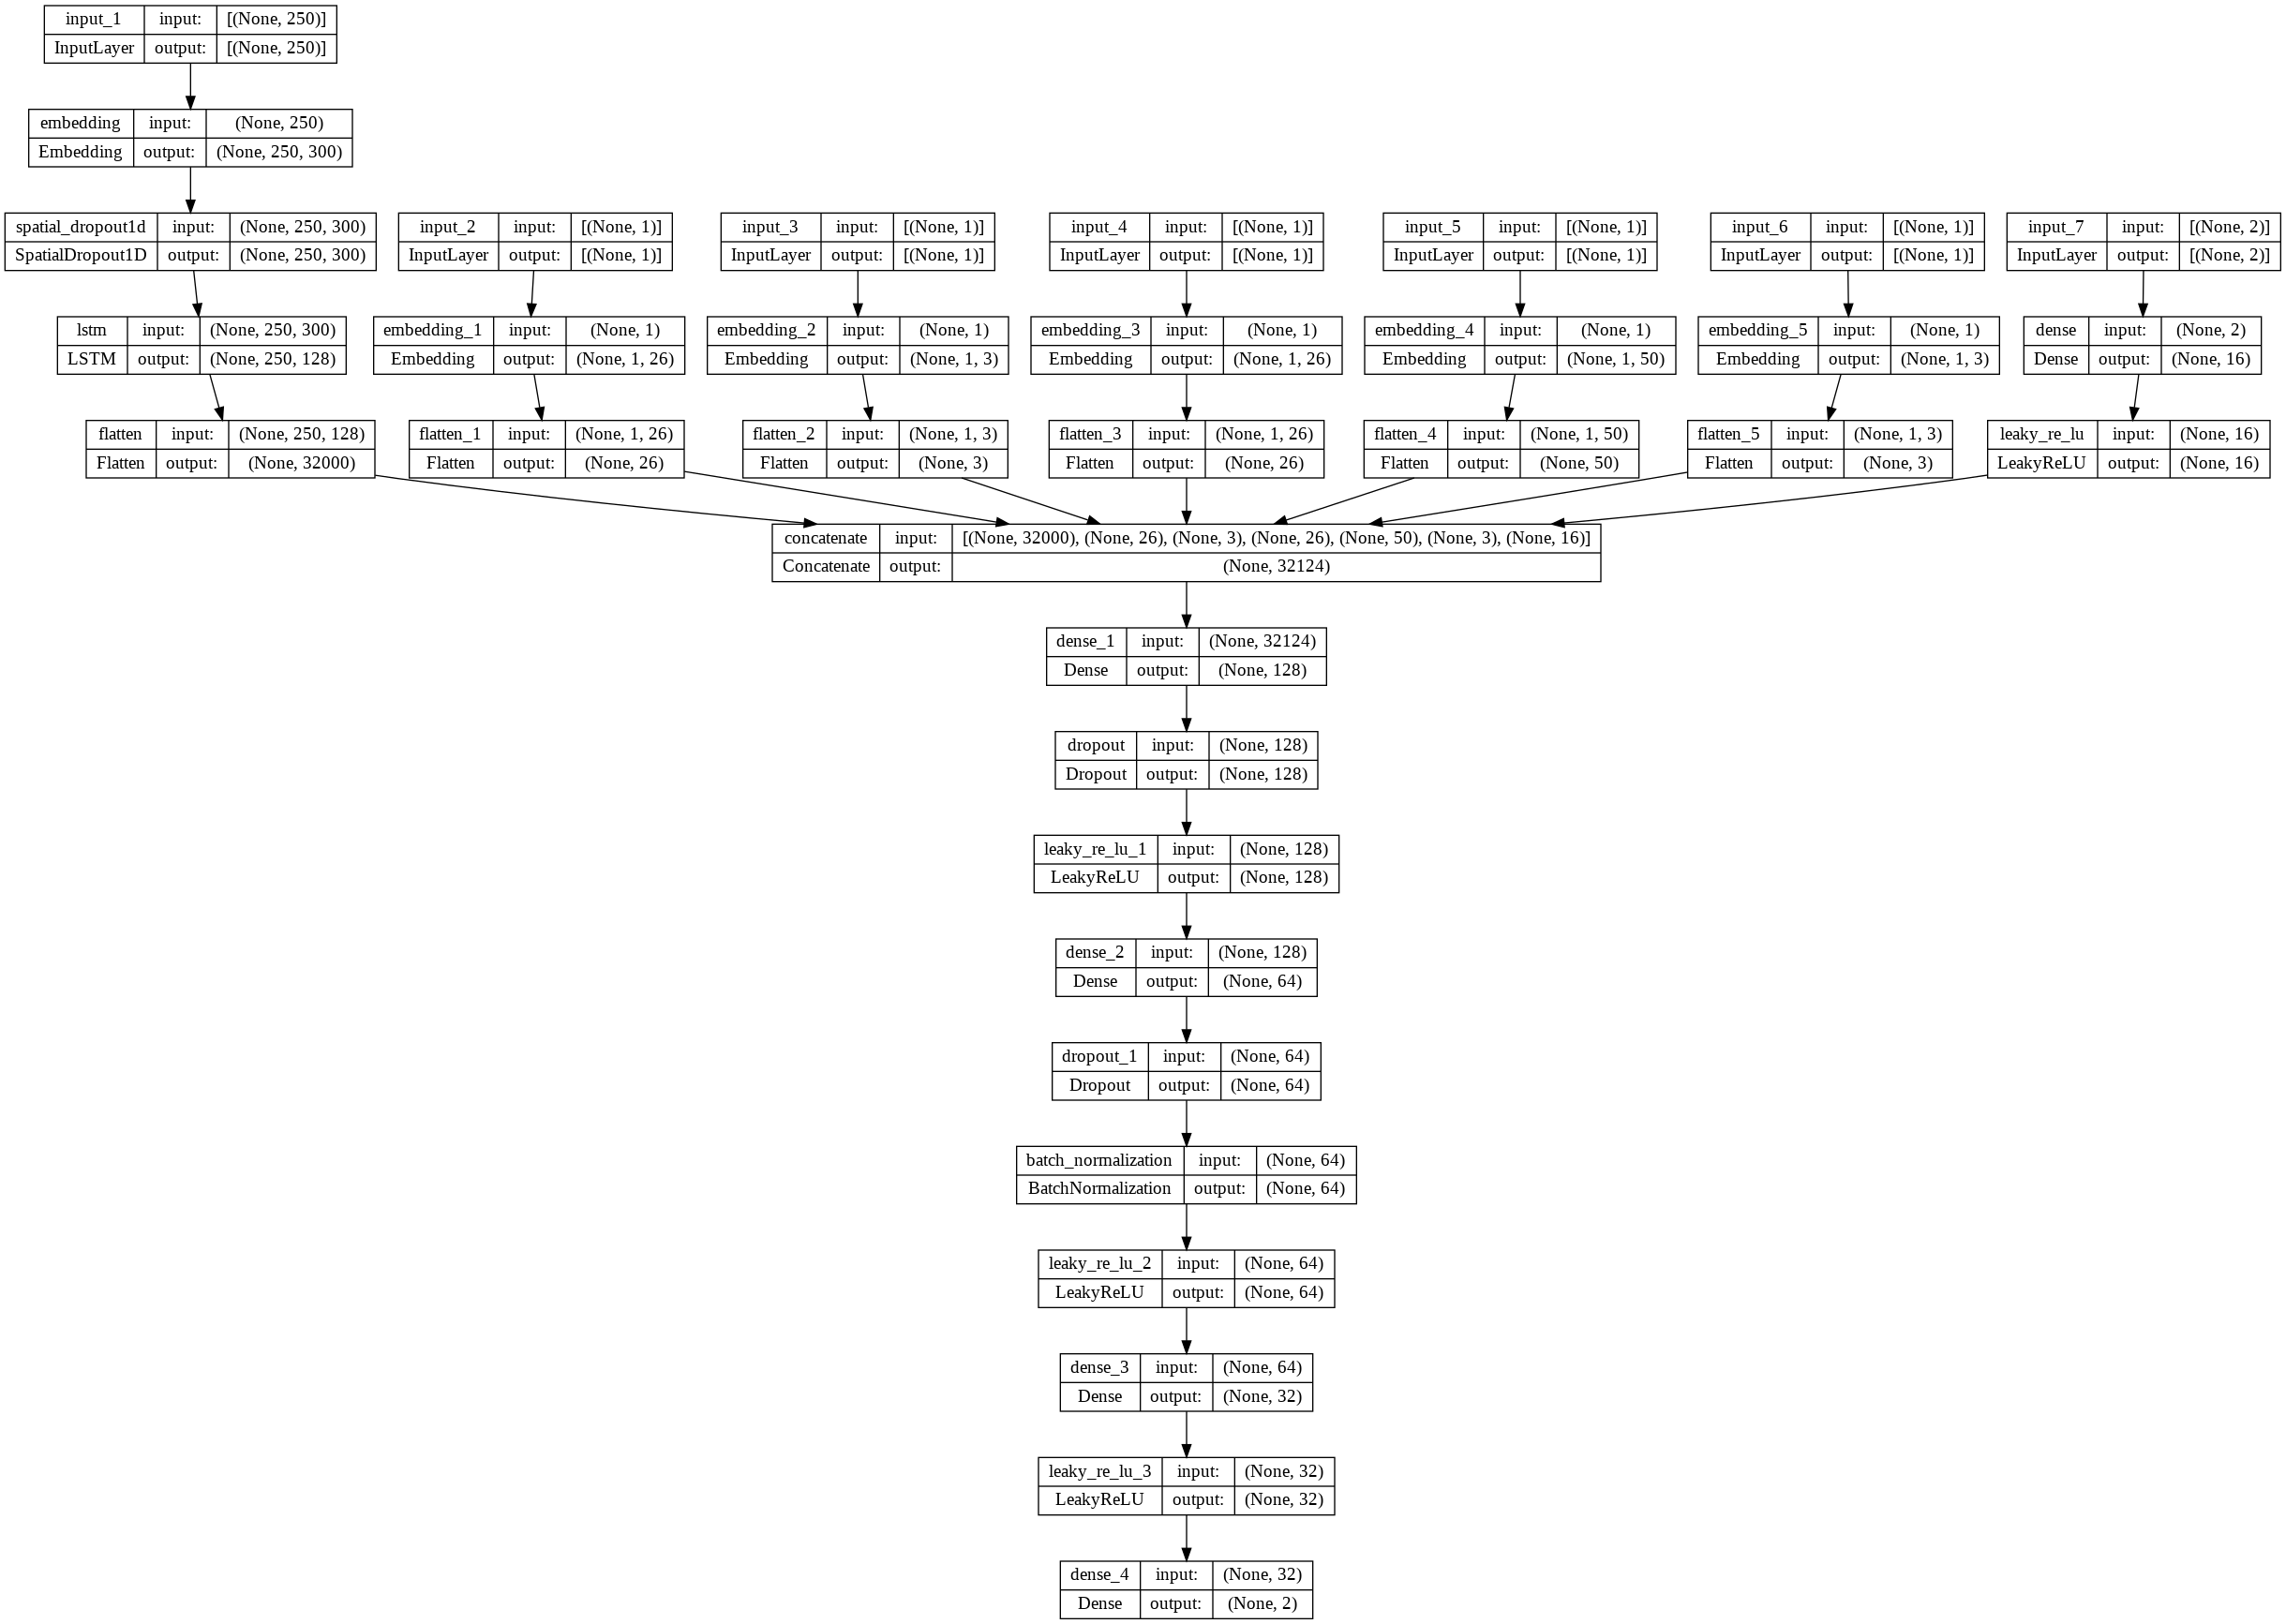

In [ ]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/lstm donor choose/lstm_output/model_1.png', show_shapes=True, show_layer_names=True)

In [ ]:
# with open('/content/drive/My Drive/LSTM Output/abc.gdoc', 'w') as f:
#   f.write('content')

#model fitting
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath="/content/drive/MyDrive/lstm donor choose/lstm_output"

earlystopping_1 = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint,tensorboard,earlystopping_1]

model.fit([X_train_essay, X_train_school_state_ohe, X_train_project_grade_category_ohe, X_train_clean_categories_ohe, X_train_clean_subcategories_ohe, X_train_teacher_prefix_ohe,X_train_numerical_input_data], y_train, nb_epoch=50, verbose=1, batch_size=256, validation_data=([X_cv_essay, X_cv_school_state_ohe, X_cv_project_grade_category_ohe, X_cv_clean_categories_ohe, X_cv_clean_subcategories_ohe, X_cv_teacher_prefix_ohe,X_cv_numerical_input_data]  , y_cv), callbacks = callbacks_list)

Train on 69918 samples, validate on 17480 samples
Epoch 1/50
69918/69918 [==============================] - ETA: 0s - loss: 0.9133 - accuracy: 0.8324 - auc: 0.5992
Epoch 1: val_auc improved from -inf to 0.69633, saving model to /content/drive/MyDrive/lstm donor choose/lstm_output
69918/69918 [==============================] - 99s 1ms/sample - loss: 0.9133 - accuracy: 0.8324 - auc: 0.5992 - val_loss: 0.6819 - val_accuracy: 0.8483 - val_auc: 0.6963
Epoch 2/50
69918/69918 [==============================] - ETA: 0s - loss: 0.6014 - accuracy: 0.8483 - auc: 0.6674
Epoch 2: val_auc improved from 0.69633 to 0.71827, saving model to /content/drive/MyDrive/lstm donor choose/lstm_output
69918/69918 [==============================] - 94s 1ms/sample - loss: 0.6014 - accuracy: 0.8483 - auc: 0.6674 - val_loss: 0.5443 - val_accuracy: 0.8486 - val_auc: 0.7183
Epoch 3/50
69918/69918 [==============================] - ETA: 0s - loss: 0.5279 - accuracy: 0.8483 - auc: 0.6899
Epoch 3: val_auc improved from 

#  Load model_1 with best weights

In [ ]:
# Load model with best weights

#input 1 essay text
input1 = Input(shape=(250,))
x1 = Embedding(input_dim=vocab_size,output_dim= 300,weights=[embedding_matrix],trainable=False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = LSTM(128,return_sequences=True,dropout=0.5,kernel_regularizer=regularizers.l2(0.001))(x1)
x1 = Flatten()(x1)

#https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9
cat_vars = ["teacher_prefix","school_state","project_grade_category","clean_categories","clean_subcategories"]
cat_sizes = {}
cat_embsizes = {}
for cat in cat_vars:
    cat_sizes[cat] = X_train[cat].nunique()
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)  

# input 2 school_state 51
input2 = Input(shape=(1,))
x2 = Embedding(input_dim=cat_sizes['school_state']+1, output_dim=cat_embsizes['school_state'])(input2)#input_dim=52
x2 = Flatten()(x2)

# input 3 project_grade_cat 4
input3 = Input(shape=(1,))
x3 = Embedding(input_dim=cat_sizes['project_grade_category']+1, output_dim=cat_embsizes['project_grade_category'])(input3)
x3 = Flatten()(x3)

# input 4 clean_categories 9
input4 = Input(shape=(1,))
x4 = Embedding(input_dim=cat_sizes['clean_categories']+1, output_dim=cat_embsizes['clean_categories'])(input4)
x4 = Flatten()(x4)

# input 5 clean_subcategories 30
input5 = Input(shape=(1,))
x5 = Embedding(input_dim=cat_sizes['clean_subcategories']+1, output_dim=cat_embsizes['clean_subcategories'])(input5)
x5 = Flatten()(x5)

# input 6 teacher_prefix 5
input6 = Input(shape=(1,))
x6 = Embedding(input_dim=cat_sizes['teacher_prefix']+1, output_dim=cat_embsizes['teacher_prefix'])(input6)
x6 = Flatten()(x6)

# print(cat_concat)

#input 7 remaining inout
input7 = Input(shape=(2,))
x7 = Dense(32,kernel_initializer=he_normal(),kernel_regularizer=l2(0.001))(input7)
x7 = LeakyReLU()(x7)

concat = concatenate([x1, x2, x3, x4, x5, x6, x7])

x = Dense(128,kernel_initializer=he_normal(),kernel_regularizer=l2(0.001))(concat)
x = Dropout(0.5)(x)
x = LeakyReLU()(x)
x = Dense(64,kernel_initializer=he_normal(),kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(32,kernel_initializer=he_normal(),kernel_regularizer=l2(0.001))(x)
x = LeakyReLU()(x)
# x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)

# create model with seven inputs
model = Model([input1,input2,input3,input4,input5,input6,input7], output)#
model.run_eagerly = True
#tensorboard = TensorBoard(log_dir='/content/drive/My Drive/LSTM Output/logs_best/{}'.format(time()))
# tensorboard = TensorBoard(log_dir='logs')
model.load_weights(filepath)#"weights_copy.best.hdf5"
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0006,decay = 1e-4),metrics=['accuracy', auc])


In [ ]:
print("AUC for test data: %0.3f"%roc_auc_score(y_test,model.predict([X_test_essay, X_test_school_state_ohe, X_test_project_grade_category_ohe, X_test_clean_categories_ohe, X_test_clean_subcategories_ohe, X_test_teacher_prefix_ohe, X_test_numerical_input_data])))
print("AUC for CV data: %0.3f"%roc_auc_score(y_cv,model.predict([X_cv_essay, X_cv_school_state_ohe, X_cv_project_grade_category_ohe, X_cv_clean_categories_ohe, X_cv_clean_subcategories_ohe, X_cv_teacher_prefix_ohe,X_cv_numerical_input_data])))
print("AUC for train data: %0.3f"%roc_auc_score(y_train,model.predict([X_train_essay, X_train_school_state_ohe, X_train_project_grade_category_ohe, X_train_clean_categories_ohe, X_train_clean_subcategories_ohe, X_train_teacher_prefix_ohe, X_train_numerical_input_data])))

AUC for test data: 0.747
AUC for CV data: 0.751
AUC for train data: 0.763


In [ ]:
%load_ext tensorboard

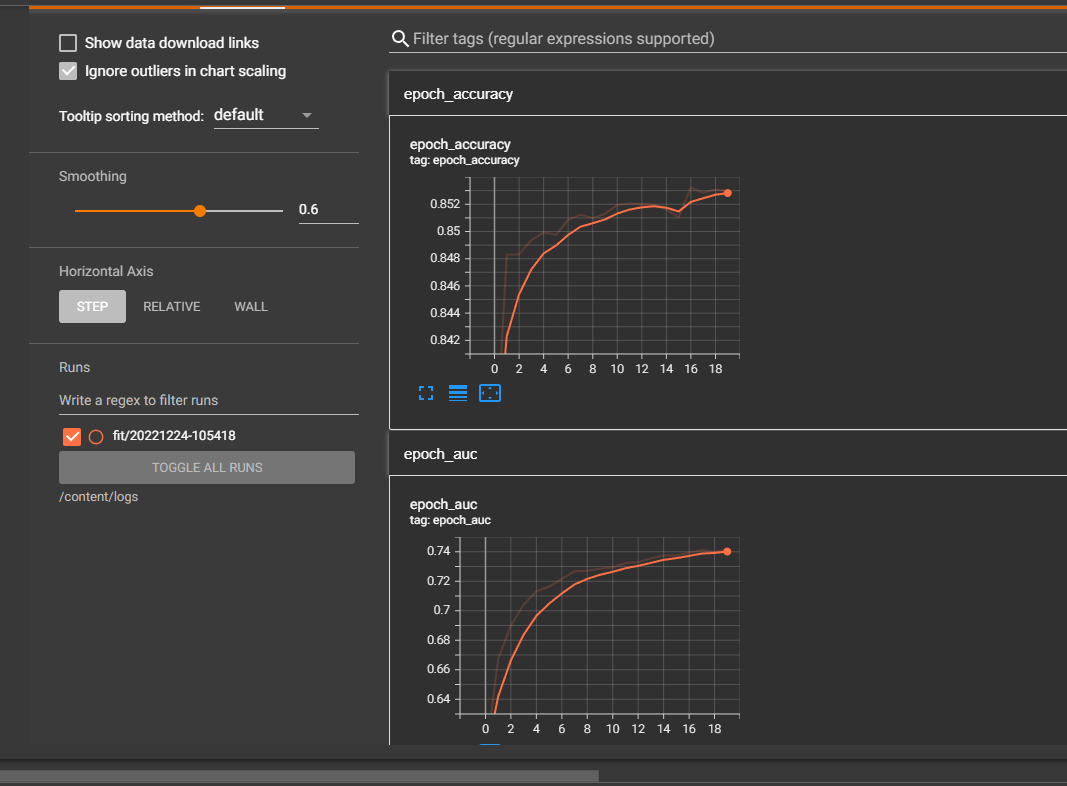

# Instruction

In [ ]:
#text---------------------------
#since the data is already preprocessed, we can directly move to vectorization part
#first we will vectorize the text data
#for vectorization of text data in deep learning we use tokenizer, you can go through below references
# https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html
#https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do
# after text vectorization you should get train_padded_docs and test_padded_docs

#after getting the padded_docs you have to use predefined glove vectors to get 300 dim representation for each word
# we will be storing this data in form of an embedding matrix and will use it while defining our model
# Please go through following blog's 'Example of Using Pre-Trained GloVe Embedding' section to understand how to create embedding matrix
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

#categoty----------------------------
# for model 1 and model 2, we have to assign a unique number to each feature in a particular categorical column.
# you can either use tokenizer,label encoder or ordinal encoder to perform the task
# label encoder gives an error for 'unseen values' (values present in test but not in train)
# handle unseen values with label encoder - https://stackoverflow.com/a/56876351
# ordinal encoder also gives error with unseen values but you can use modify handle_unknown parameter
# documentation of ordianl encoder https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html
# after categorical feature vectorization you will have column_train_data and column_test_data.


#numeric-------------------
# you have to standardise the numerical columns
# stack both the numerical features
#after numerical feature vectorization you will have numerical_data_train and numerical_data_test

## 1.4 Defining the model

<img src='https://i.imgur.com/w395Yk9.png'>

In [ ]:
# as of now we have vectorized all our features now we will define our model.
# as it is clear from above image that the given model has multiple input layers and hence we have to use functional API
# Please go through - https://keras.io/guides/functional_api/
# it is a good programming practise to define your complete model i.e all inputs , intermediate and output layers at one place.
# while defining your model make sure that you use variable names while defining any length,dimension or size.
#for ex.- you should write the code as 'input_text = Input(shape=(pad_length,))' and not as 'input_text = Input(shape=(300,))'
# the embedding layer for text data should be non trainable
# the embedding layer for categorical data should be trainable
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
# https://towardsdatascience.com/deep-embeddings-for-categorical-variables-cat2vec-b05c8ab63ac0
#print model.summary() after you have defined the model
#plot the model using utils.plot_model module and make sure that it is similar to the above image

## 1.5 Compiling and fititng your model

In [ ]:
#define custom auc as metric , do not use tf.keras.metrics
# https://stackoverflow.com/a/46844409 - custom AUC reference 1
# https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/80807  - custom AUC reference 2
# compile and fit your model

# <font color='red'> Model-2 </font>

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Fit TF-IDF vectorizer on the Train data <br>
2. Get the idf value for each word we have in the train data. Please go through <a  href='https://stackoverflow.com/questions/23792781/tf-idf-feature-weights-using-sklearn-feature-extraction-text-tfidfvectorizer'>this</a><br>

3. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very 
frequent words and very very rare words don't give much information.
Hint - A preferable IDF range is 2-11 for model 2. <br>
4.Remove the low idf value and high idf value words from the train and test data. You can go through each of the
sentence of train and test data and include only those features(words) which are present in the defined IDF range.
5. Perform tokenization on the modified text data same as you have done for previous model.
6. Create embedding matrix for model 2 and then use the rest of the features similar to previous model.
7. Define the model, compile and fit the model.
</pre>

# Getting the idf values for each word and choose words which have idf value between 2 and 9 is choosen as text essay data

In [ ]:
vectorizer = TfidfVectorizer(min_df=10,max_features=10000) #Defining TFIDF with min_df=10
imp_tf = vectorizer.fit(X_train['essay'])

In [ ]:
idf_values = vectorizer.idf_ 

In [ ]:
df = pd.DataFrame(idf_values, columns= ["idf"])
df.head()

,idf
0,7.171486
1,5.845174
2,4.478156
3,3.814398
4,7.124655


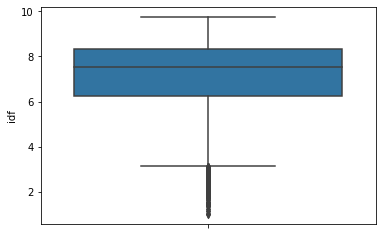

In [ ]:
import seaborn as sns

sns.boxplot(y = "idf", data = df )

In [ ]:
for i in range(0,100,5):
    var =idf_values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 1.0078252716372125
5 percentile value is 4.1088636070922675
10 percentile value is 4.9576573540710545
15 percentile value is 5.465493438988679
20 percentile value is 5.872825961271638
25 percentile value is 6.260689873902794
30 percentile value is 6.594411077152117
35 percentile value is 6.861787883443153
40 percentile value is 7.111667591248398
45 percentile value is 7.342908352795228
50 percentile value is 7.5399721913263855
55 percentile value is 7.724275909324332
60 percentile value is 7.89241283112633
65 percentile value is 8.044218843994333
70 percentile value is 8.203848989586218
75 percentile value is 8.348430218397326
80 percentile value is 8.491531062038
85 percentile value is 8.628732183551485
90 percentile value is 8.787796878181172
95 percentile value is 8.896996170146164
100 percentile value is  9.757197435369275


In [ ]:
feature_idf = zip(imp_tf.get_feature_names(),idf_values)

feature_name = []
for x,y in feature_idf:
    
    if y >= 2 and y <= 9:   #choosing words which have idf value beween 2 and 9 
        feature_name.append(x)

print(len(feature_name))

9740


In [ ]:
print(feature_name)

['00', '000', '10', '100', '1000', '101', '10th', '11', '110', '115', '11th', '12', '120', '1200', '125', '12th', '13', '130', '14', '140', '1400', '15', '150', '1500', '16', '160', '1600', '17', '170', '18', '180', '1800', '19', '1st', '20', '200', '2000', '2003', '2004', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '20th', '21', '21st', '22', '23', '24', '25', '250', '26', '27', '28', '280', '29', '2d', '2nd', '30', '300', '3000', '31', '32', '320', '33', '34', '35', '350', '36', '360', '365', '37', '38', '39', '3d', '3doodler', '3doodlers', '3rd', '40', '400', '41', '42', '43', '44', '45', '450', '46', '47', '48', '480', '49', '4k', '4th', '50', '500', '504', '51', '52', '53', '54', '55', '550', '56', '560', '57', '58', '5k', '5th', '60', '600', '61', '62', '63', '64', '65', '650', '66', '67', '68', '69', '6th', '70', '700', '71', '72', '73', '74', '75', '750', '76', '77', '78', '79', '7th', '80', '800', '81', '82', '83', '84', '85', '850',

In [ ]:
from tqdm import tqdm
def get_text_on_idf_features(essay_text):
  '''
  This method collects words idf value beween 2 and 9 
  '''
  preprocessed_text = []
  # Iterate each essay text
  for sent in tqdm(essay_text):
    words = sent.split()
    final_sent = ''
    # Iterate for each esssay word
    for word in words:
      # Check word exists in idf corpus
      if(word in feature_name):
        final_sent += ' ' + word
        
    preprocessed_text.append(final_sent)

  return preprocessed_text 


In [ ]:
X_train['essay']

36575     as new teacher low income high poverty school ...
100169    our classroom made 16 18 diverse energetic 7 8...
1942      technology plays important role every person l...
56259     in 5th grade classroom diverse class many diff...
51209     i teach southeast washington dc the school tit...
                                ...                        
90571     my students amazing group diverse fifth grader...
45864     i greatest classes in the world i lot students...
74101     my 4th grade students complex creative thought...
7870      i work small groups k 5 students throughout da...
45813     despite living low income high poverty area ki...
Name: essay, Length: 69918, dtype: object

In [ ]:
X_train_essay_orig = X_train['essay']

In [ ]:
# filter train data
X_train_shot = []
X_train_shot = get_text_on_idf_features(X_train['essay'])


In [ ]:
X_cv_essay_orig = X_cv['essay']

In [ ]:
# filter cv data
#X_cv_essay_orig = X_cv['essay']
X_cv_shot = []
X_cv_shot = get_text_on_idf_features(X_cv['essay'])
len(X_cv_shot)

100%|██████████| 17480/17480 [04:48<00:00, 60.68it/s]


17480

In [ ]:
X_test_essay_orig = X_test['essay']

In [ ]:
# filter test data

X_test_shot = []
X_test_shot = get_text_on_idf_features(X_test['essay'])
len(X_test_shot)

100%|██████████| 21850/21850 [06:00<00:00, 60.62it/s]


21850

In [ ]:
#https://stackoverflow.com/posts/51956230/revisions
t = Tokenizer()
t.fit_on_texts(X_train_shot)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_train_shot)
X_train_essay = padded(encoded_docs)

In [ ]:

# integer encode the documents
encoded_docs = t.texts_to_sequences(X_cv_shot)
X_cv_essay = padded(encoded_docs)

In [ ]:

# integer encode the documents
encoded_docs = t.texts_to_sequences(X_test_shot)
X_test_essay = padded(encoded_docs)

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
# Create model 1 for assignment 2

#input 1 essay text
input1 = Input(shape=(250,))
# x1 = Embedding(input_dim=49042,output_dim= 300)(input1)
x1 = Embedding(input_dim=vocab_size, output_dim= 300,weights=[embedding_matrix],trainable=False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = LSTM(128,return_sequences=True)(x1)
# x1 = LSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9
cat_vars = ["teacher_prefix","school_state","project_grade_category","clean_categories","clean_subcategories"]
cat_sizes = {}
cat_embsizes = {}
for cat in cat_vars:
    cat_sizes[cat] = X_train[cat].nunique()
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)  

# input 2 school_state 51
input2 = Input(shape=(1,))
x2 = Embedding(input_dim=cat_sizes['school_state']+1, output_dim=cat_embsizes['school_state'])(input2)#input_dim=52
x2 = Flatten()(x2)

# input 3 project_grade_cat 4
input3 = Input(shape=(1,))
x3 = Embedding(input_dim=cat_sizes['project_grade_category']+1, output_dim=cat_embsizes['project_grade_category'])(input3)
x3 = Flatten()(x3)

# input 4 clean_categories 9
input4 = Input(shape=(1,))
x4 = Embedding(input_dim=cat_sizes['clean_categories']+1, output_dim=cat_embsizes['clean_categories'])(input4)
x4 = Flatten()(x4)

# input 5 clean_subcategories 30
input5 = Input(shape=(1,))
x5 = Embedding(input_dim=cat_sizes['clean_subcategories']+1, output_dim=cat_embsizes['clean_subcategories'])(input5)
x5 = Flatten()(x5)

# input 6 teacher_prefix 5
input6 = Input(shape=(1,))
x6 = Embedding(input_dim=cat_sizes['teacher_prefix']+1, output_dim=cat_embsizes['teacher_prefix'])(input6)
x6 = Flatten()(x6)

# print(cat_concat)

#input 7 remaining inout
input7 = Input(shape=(2,))
x7 = Dense(16,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input7)
x7 = LeakyReLU()(x7)

concat = concatenate([x1, x2, x3, x4, x5, x6, x7])

x = Dense(128,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.5)(x)
x = LeakyReLU()(x)
x = Dense(64,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(32,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = LeakyReLU()(x)
# x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)

# create model with seven inputs
model = Model([input1,input2,input3,input4,input5,input6,input7], output)#
model.run_eagerly = True
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # tensorboard
tensorboard = TensorBoard(log_dir=logdir)
# tensorboard = TensorBoard(log_dir='logs')
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0006,decay = 1e-4),metrics=['accuracy', auc])
print(model.summary())

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_87 (InputLayer)          [(None, 250)]        0           []                               
                                                                                                  
 embedding_74 (Embedding)       (None, 250, 300)     2916600     ['input_87[0][0]']               
                                                                                                  
 spatial_dropout1d_13 (SpatialD  (None, 250, 300)    0           ['embedding_74[0][0]']           
 ropout1D)                                                                                        
                                                                                                  
 input_88 (InputLayer)          [(None, 1)]          0           []                        

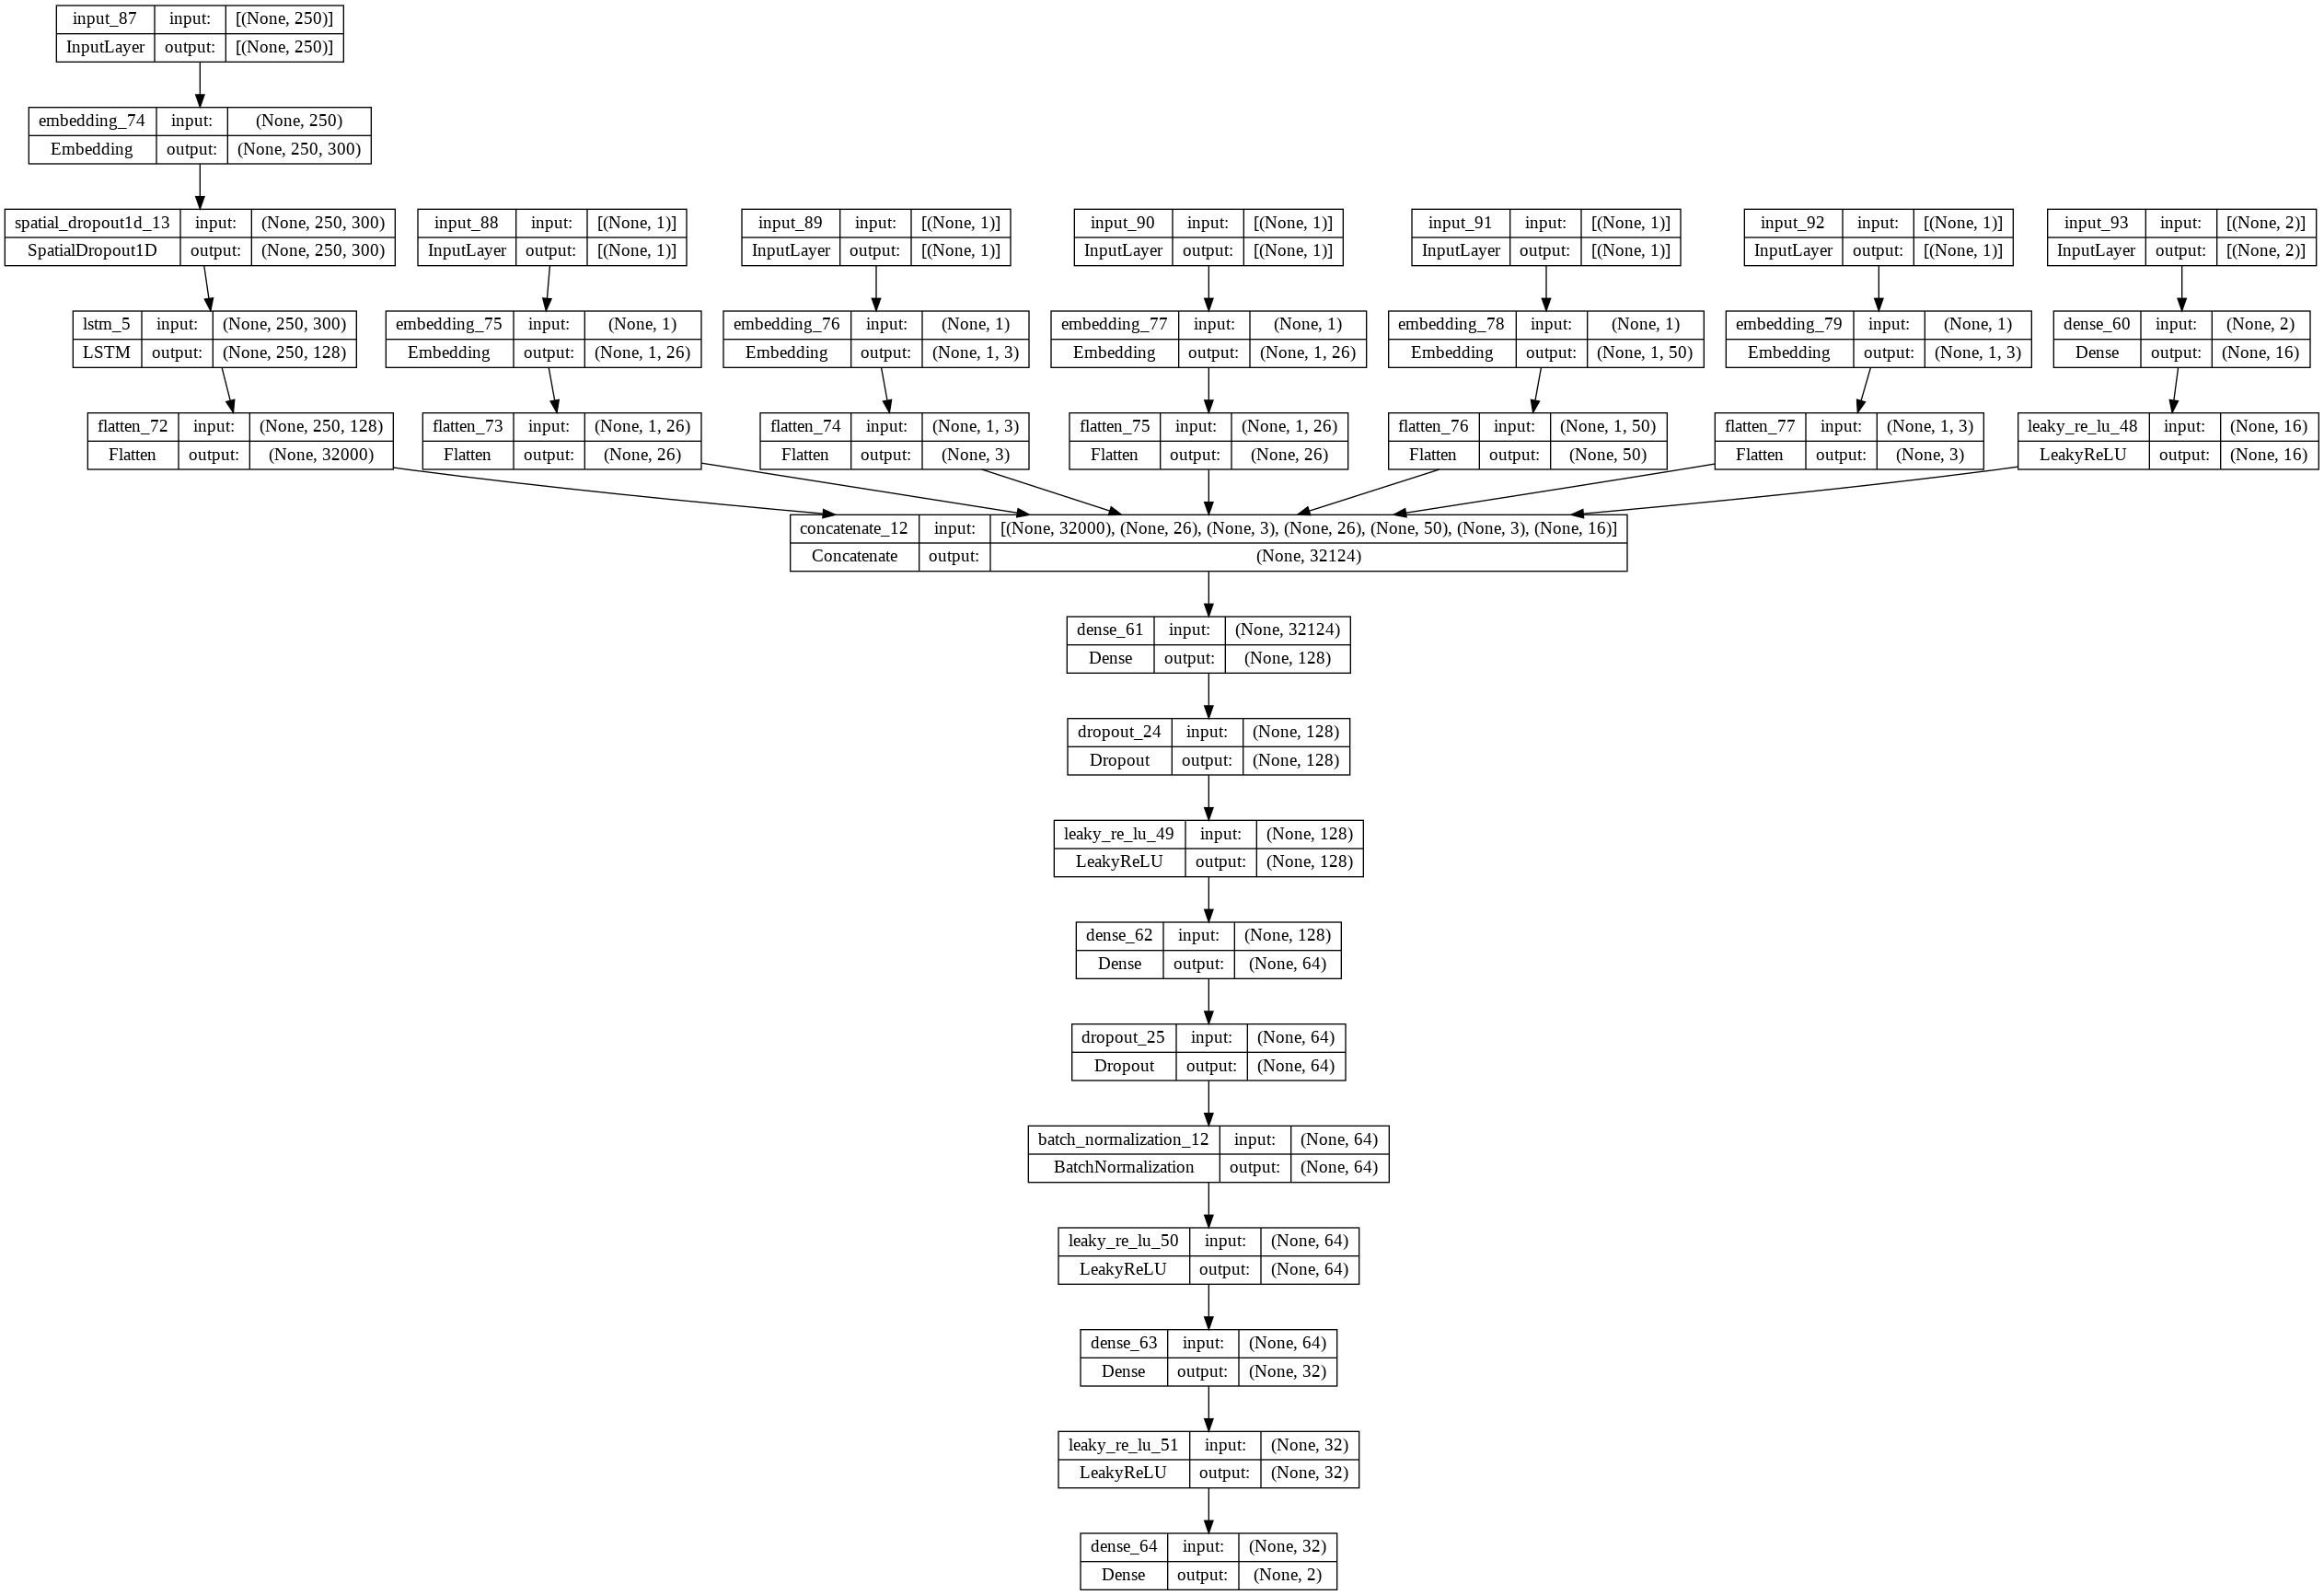

In [ ]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/lstm donor choose/lstm_output/model_2.png', show_shapes=True, show_layer_names=True)

In [ ]:
# with open('/content/drive/My Drive/LSTM Output/abc.gdoc', 'w') as f:
#   f.write('content')

#model fitting
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath="/content/drive/MyDrive/lstm donor choose/lstm_output/weights_copy_new_23_2.best.hdf5"

earlystopping_1 = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint,tensorboard,earlystopping_1]

model.fit([X_train_essay, X_train_school_state_ohe, X_train_project_grade_category_ohe, X_train_clean_categories_ohe, X_train_clean_subcategories_ohe, X_train_teacher_prefix_ohe, X_train_numerical_input_data], y_train, nb_epoch=50, verbose=1, batch_size=256, validation_data=([X_cv_essay, X_cv_school_state_ohe, X_cv_project_grade_category_ohe, X_cv_clean_categories_ohe, X_cv_clean_subcategories_ohe, X_cv_teacher_prefix_ohe,X_cv_numerical_input_data]  , y_cv), callbacks = callbacks_list)


Train on 69918 samples, validate on 17480 samples
Epoch 1/50
69918/69918 [==============================] - ETA: 0s - loss: 0.4822 - accuracy: 0.8379 - auc: 0.6180
Epoch 1: val_auc improved from -inf to 0.70025, saving model to /content/drive/MyDrive/lstm donor choose/lstm_output/weights_copy_new_23_2.best.hdf5
69918/69918 [==============================] - 109s 2ms/sample - loss: 0.4822 - accuracy: 0.8379 - auc: 0.6180 - val_loss: 0.4544 - val_accuracy: 0.8491 - val_auc: 0.7002
Epoch 2/50
69918/69918 [==============================] - ETA: 0s - loss: 0.4339 - accuracy: 0.8488 - auc: 0.6949
Epoch 2: val_auc improved from 0.70025 to 0.72710, saving model to /content/drive/MyDrive/lstm donor choose/lstm_output/weights_copy_new_23_2.best.hdf5
69918/69918 [==============================] - 87s 1ms/sample - loss: 0.4339 - accuracy: 0.8488 - auc: 0.6949 - val_loss: 0.4280 - val_accuracy: 0.8518 - val_auc: 0.7271
Epoch 3/50
69918/69918 [==============================] - ETA: 0s - loss: 0.4194

In [ ]:
# Load model with best weights for assignment 2

#input 1 essay text
input1 = Input(shape=(250,))
# x1 = Embedding(input_dim=49042,output_dim= 300)(input1)
x1 = Embedding(input_dim=vocab_size,output_dim= 300,weights=[embedding_matrix],trainable=False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = LSTM(128,return_sequences=True)(x1)
# x1 = LSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9
cat_vars = ["teacher_prefix","school_state","project_grade_category","clean_categories","clean_subcategories"]
cat_sizes = {}
cat_embsizes = {}
for cat in cat_vars:
    cat_sizes[cat] = X_train[cat].nunique()
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)  

# input 2 school_state 51
input2 = Input(shape=(1,))
x2 = Embedding(input_dim=cat_sizes['school_state']+1, output_dim=cat_embsizes['school_state'])(input2)#input_dim=52
x2 = Flatten()(x2)

# input 3 project_grade_cat 4
input3 = Input(shape=(1,))
x3 = Embedding(input_dim=cat_sizes['project_grade_category']+1, output_dim=cat_embsizes['project_grade_category'])(input3)
x3 = Flatten()(x3)

# input 4 clean_categories 9
input4 = Input(shape=(1,))
x4 = Embedding(input_dim=cat_sizes['clean_categories']+1, output_dim=cat_embsizes['clean_categories'])(input4)
x4 = Flatten()(x4)

# input 5 clean_subcategories 30
input5 = Input(shape=(1,))
x5 = Embedding(input_dim=cat_sizes['clean_subcategories']+1, output_dim=cat_embsizes['clean_subcategories'])(input5)
x5 = Flatten()(x5)

# input 6 teacher_prefix 5
input6 = Input(shape=(1,))
x6 = Embedding(input_dim=cat_sizes['teacher_prefix']+1, output_dim=cat_embsizes['teacher_prefix'])(input6)
x6 = Flatten()(x6)

# print(cat_concat)

#input 7 remaining inout
input7 = Input(shape=(2,))
x7 = Dense(16,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input7)
x7 = LeakyReLU()(x7)

concat = concatenate([x1, x2, x3, x4, x5, x6, x7])

x = Dense(128,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.5)(x)
x = LeakyReLU()(x)
x = Dense(64,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(32,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = LeakyReLU()(x)
# x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)

# create model with seven inputs
model = Model([input1,input2,input3,input4,input5,input6,input7], output)#
model.run_eagerly = True
logdir="logs/fit_best/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # tensorboard
tensorboard = TensorBoard(log_dir=logdir)
# tensorboard = TensorBoard(log_dir='logs')
model.load_weights(filepath)
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0006,decay = 1e-4),metrics=['accuracy', auc])

In [ ]:
print("AUC for test data: %0.3f"%roc_auc_score(y_test,model.predict([X_test_essay, X_test_school_state_ohe, X_test_project_grade_category_ohe, X_test_clean_categories_ohe, X_test_clean_subcategories_ohe, X_test_teacher_prefix_ohe,X_test_numerical_input_data])))
print("AUC for CV data: %0.3f"%roc_auc_score(y_cv,model.predict([X_cv_essay, X_cv_school_state_ohe, X_cv_project_grade_category_ohe, X_cv_clean_categories_ohe, X_cv_clean_subcategories_ohe, X_cv_teacher_prefix_ohe,X_cv_numerical_input_data])))
print("AUC for train data: %0.3f"%roc_auc_score(y_train,model.predict([X_train_essay, X_train_school_state_ohe, X_train_project_grade_category_ohe, X_train_clean_categories_ohe, X_train_clean_subcategories_ohe, X_train_teacher_prefix_ohe,X_train_numerical_input_data])))

AUC for test data: 0.742
AUC for CV data: 0.742
AUC for train data: 0.816


In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


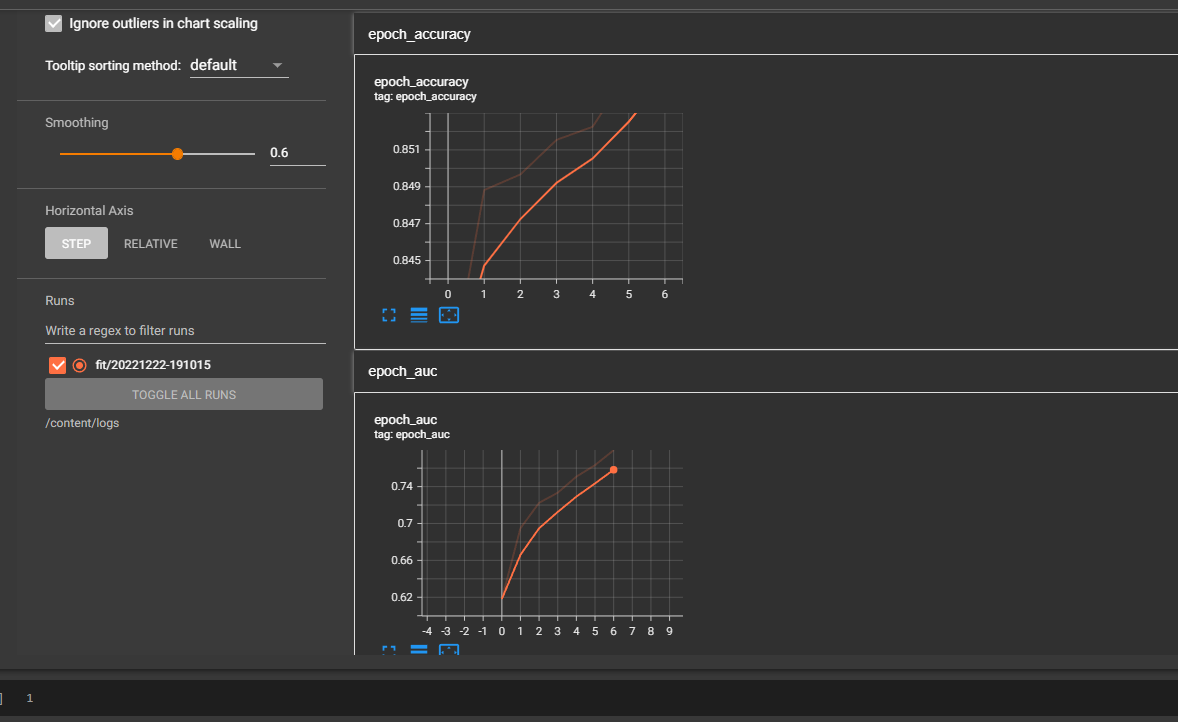

# <font color='red'> Model-3 </font>

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png

In [ ]:
#in this model you can use the text vectorized data from model1 
#for other than text data consider the following steps
# you have to perform one hot encoding of categorical features. You can use onehotencoder() or countvectorizer() for the same.
# Stack up standardised numerical features and all the one hot encoded categorical features
#the input to conv1d layer is 3d, you can convert your 2d data to 3d using np.newaxis
# Note - deep learning models won't work with sparse features, you have to convert them to dense features before fitting in the model.

# One hot ending of categorical features

In [ ]:
# process other than text data
# Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors
# Neumerical values

# One hot encoding of Categorical Feature
# - school_state : categorical data
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values)# Fit has to happen only on train data

X_train_school_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_school_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_school_state_ohe = vectorizer.transform(X_test['school_state'].values)

school_state_features = vectorizer.get_feature_names()

print(X_train_school_state_ohe.shape, y_train.shape)
print(X_cv_school_state_ohe.shape, y_cv.shape)
print(X_test_school_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)

(69918, 51) (69918, 2)
(17480, 51) (17480, 2)
(21850, 51) (21850, 2)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
****************************************************************************************************


In [ ]:
# One hot encoding of Categorical Feature
# - clean_categories : categorical data
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values)# Fit has to happen only on train data

X_train_clean_categories_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_clean_categories_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_clean_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)

clean_categories_features = vectorizer.get_feature_names()

print(X_train_clean_categories_ohe.shape, y_train.shape)
print(X_cv_clean_categories_ohe.shape, y_cv.shape)
print(X_test_clean_categories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)

(69918, 9) (69918, 2)
(17480, 9) (17480, 2)
(21850, 9) (21850, 2)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
****************************************************************************************************


In [ ]:
# One hot encoding of Categorical Feature
# - clean_subcategories : categorical data
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values)# Fit has to happen only on train data

X_train_clean_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_clean_subcategories_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_clean_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

clean_subcategories_features = vectorizer.get_feature_names()

print(X_train_clean_subcategories_ohe.shape, y_train.shape)
print(X_cv_clean_subcategories_ohe.shape, y_cv.shape)
print(X_test_clean_subcategories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)

(69918, 30) (69918, 2)
(17480, 30) (17480, 2)
(21850, 30) (21850, 2)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
****************************************************************************************************


In [ ]:
print(X_train['project_grade_category'])
# One hot encoding of Categorical Feature
# - project_grade_category : categorical data
# Convert one hot encoding for project grade category
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values)# Fit has to happen only on train data

X_train_project_grade_category_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_project_grade_category_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_project_grade_category_ohe = vectorizer.transform(X_test['project_grade_category'].values)

project_grade_category_features = vectorizer.get_feature_names()

print(X_train_project_grade_category_ohe.shape, y_train.shape)
print(X_cv_project_grade_category_ohe.shape, y_cv.shape)
print(X_test_project_grade_category_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)

31767        grades_6_8
33156     grades_prek_2
18113        grades_6_8
102735      grades_9_12
152       grades_prek_2
              ...      
96752        grades_6_8
94458       grades_9_12
95668        grades_6_8
72544        grades_6_8
43820        grades_3_5
Name: project_grade_category, Length: 69918, dtype: object
(69918, 4) (69918, 2)
(17480, 4) (17480, 2)
(21850, 4) (21850, 2)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
****************************************************************************************************


In [ ]:
# One hot encoding of Categorical Feature
# - teacher_prefix : categorical data
print(X_train['teacher_prefix'])
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values)# Fit has to happen only on train data

X_train_teacher_prefix_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_clean_teacher_prefix_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_clean_teacher_prefix_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

teacher_prefix_features = vectorizer.get_feature_names()

print(X_train_teacher_prefix_ohe.shape, y_train.shape)
print(X_cv_clean_teacher_prefix_ohe.shape, y_cv.shape)
print(X_test_clean_teacher_prefix_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)

31767     mrs
33156      ms
18113      mr
102735     mr
152        ms
         ... 
96752     mrs
94458      mr
95668     mrs
72544      ms
43820      mr
Name: teacher_prefix, Length: 69918, dtype: object
(69918, 5) (69918, 2)
(17480, 5) (17480, 2)
(21850, 5) (21850, 2)
['dr', 'mr', 'mrs', 'ms', 'teacher']
****************************************************************************************************


# Stacking of all the categorical and numerical features together

In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
# X = hstack((categories_one_hot, sub_categories_one_hot, text_bow, price_standardized))
# X.shape

X_train_real = X_train
X_cv_real = X_cv
X_test_real = X_test

X_train = hstack((X_train_school_state_ohe, X_train_clean_categories_ohe, X_train_clean_subcategories_ohe, X_train_project_grade_category_ohe, X_train_teacher_prefix_ohe, X_train_numerical_input_data)).todense()
X_cv = hstack((X_cv_school_state_ohe, X_cv_clean_categories_ohe, X_cv_clean_subcategories_ohe, X_cv_project_grade_category_ohe, X_cv_clean_teacher_prefix_ohe, X_cv_numerical_input_data)).todense()
X_test = hstack((X_test_school_state_ohe, X_test_clean_categories_ohe, X_test_clean_subcategories_ohe, X_test_project_grade_category_ohe, X_test_clean_teacher_prefix_ohe, X_test_numerical_input_data)).todense()

print(X_train_real.shape)
print(X_cv_real.shape)
print(X_test_real.shape)
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(69918, 8)
(17480, 8)
(21850, 8)
(69918, 101)
(17480, 101)
(21850, 101)


# All Text data

In [ ]:
#https://stackoverflow.com/posts/51956230/revisions
t = Tokenizer()
t.fit_on_texts(X_train_essay_orig)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_train_essay_orig)
X_train_essay = padded(encoded_docs)

In [ ]:

# integer encode the documents
encoded_docs = t.texts_to_sequences(X_cv_essay_orig)
X_cv_essay = padded(encoded_docs)

In [ ]:

# integer encode the documents
encoded_docs = t.texts_to_sequences(X_test_essay_orig)
X_test_essay = padded(encoded_docs)

In [ ]:
print("After vectorizations")
print(len(X_train_essay), y_train.shape)
print(len(X_cv_essay), y_cv.shape)
print(len(X_test_essay), y_test.shape)
# print(easy_features)
# print(len(easy_features))
print("*"*100)

After vectorizations
69918 (69918, 2)
17480 (17480, 2)
21850 (21850, 2)
****************************************************************************************************


In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(69918, 101)
(17480, 101)
(21850, 101)


In [ ]:
#X_train_new = np.resize(X_train,new_shape=(69918,101))
#X_cv_new = np.resize(X_cv,new_shape=(17480,101))
#X_test_new = np.resize(X_test,new_shape=(21850,101))

In [ ]:
X_train_new = X_train[:,:, np.newaxis]
X_cv_new = X_cv[:,:, np.newaxis]
X_test_new = X_test[:,:, np.newaxis]

In [ ]:
print(X_train_new.shape)
print(X_test_new.shape)
print(X_cv_new.shape)

(69918, 101, 1)
(21850, 101, 1)
(17480, 101, 1)


In [ ]:
# Assignment #3 model 1

# input 1
input1 = Input(batch_shape=(None,250))
x1 = Embedding(input_dim=vocab_size,output_dim= 300,weights=[embedding_matrix],trainable = False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = LSTM(256,dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x1)
x1 = Flatten()(x1)

# input 2
input2 = Input(shape=(101,1))
x2 = Conv1D(filters=64,kernel_size=3,strides=1)(input2)
x2 = Conv1D(filters=64,kernel_size=3,strides=1)(x2)
x2 = Flatten()(x2)

# merging both the inputs
concat = concatenate([x1,x2])
x = Dense(512,kernel_initializer=he_normal(),kernel_regularizer=l2(0.001))(concat)
x = Dropout(0.4)(x)
x = LeakyReLU()(x)
x = Dense(256,kernel_initializer=he_normal(),kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(128,kernel_initializer=he_normal(),kernel_regularizer=l2(0.001))(x)
x = LeakyReLU()(x)
# x = Dropout(0.6)(x)
output = Dense(2, activation = 'softmax')(x)
 
# create model with two inputs
model = Model([input1,input2], output)
model.run_eagerly = True
logdir3="logs/fit3/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # tensorboard
tensorboard = TensorBoard(log_dir=logdir3)
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0006,decay = 1e-4), metrics=['accuracy', auc])
print(model.summary())

#(64 filters) * (3 filter size) * (1 input channel) + (64 filters) = 192 + 64 = 256 parameters
#64*3*64+64=12352 params

Instructions for updating:
Colocations handled automatically by placer.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 250, 300)     14179800    ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 101, 1)]     0           []                               
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 250, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                       

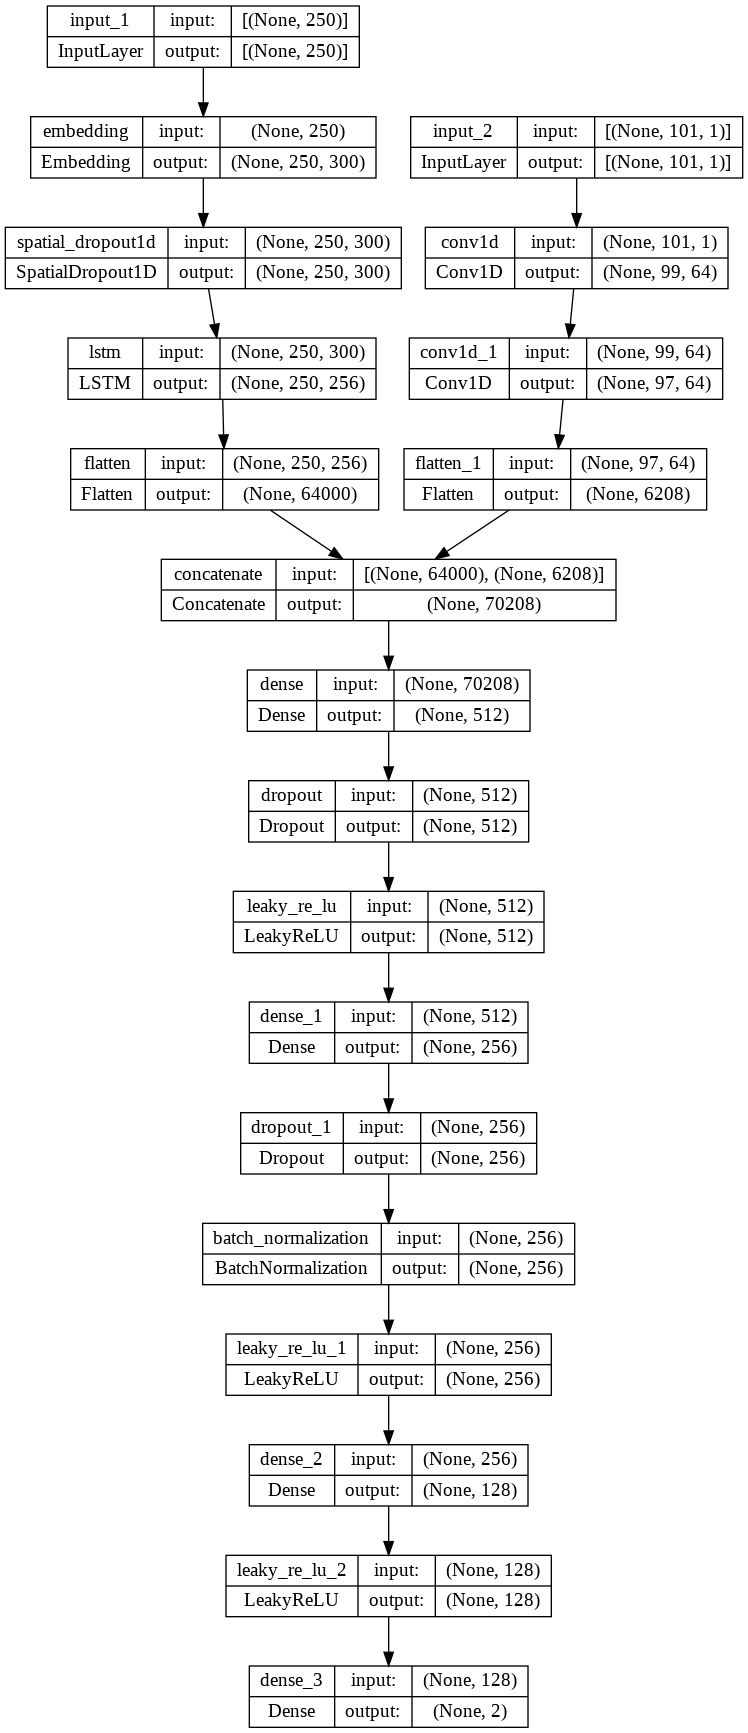

In [ ]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/lstm donor choose/lstm_output/model_3.png', show_shapes=True, show_layer_names=True)

In [ ]:
# with open('/content/drive/My Drive/LSTM Output/abc.gdoc', 'w') as f:
#   f.write('content')

#model fitting
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath="/content/drive/MyDrive/lstm donor choose/lstm_output/weights_copy_assig_3.best.hdf5"

earlystopping_1 = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint,tensorboard, earlystopping_1]

model.fit([X_train_essay, X_train_new], y_train, nb_epoch=50, verbose=1, batch_size=256, validation_data=([X_cv_essay, X_cv_new]  , y_cv), callbacks = callbacks_list)


Train on 69918 samples, validate on 17480 samples
Epoch 1/50
69918/69918 [==============================] - ETA: 0s - loss: 1.4206 - accuracy: 0.8437 - auc: 0.6110
Epoch 1: val_auc improved from -inf to 0.69530, saving model to /content/drive/MyDrive/lstm donor choose/lstm_output/weights_copy_assig_3.best.hdf5
69918/69918 [==============================] - 108s 2ms/sample - loss: 1.4206 - accuracy: 0.8437 - auc: 0.6110 - val_loss: 0.8680 - val_accuracy: 0.8486 - val_auc: 0.6953
Epoch 2/50
69918/69918 [==============================] - ETA: 0s - loss: 0.7040 - accuracy: 0.8482 - auc: 0.6721
Epoch 2: val_auc improved from 0.69530 to 0.71443, saving model to /content/drive/MyDrive/lstm donor choose/lstm_output/weights_copy_assig_3.best.hdf5
69918/69918 [==============================] - 85s 1ms/sample - loss: 0.7040 - accuracy: 0.8482 - auc: 0.6721 - val_loss: 0.6524 - val_accuracy: 0.8462 - val_auc: 0.7144
Epoch 3/50
69918/69918 [==============================] - ETA: 0s - loss: 0.5666 -

In [ ]:
# Assignment #3 model 2 with optimized weights

# input 1
input1 = Input(batch_shape=(None,250))
x1 = Embedding(input_dim=vocab_size,output_dim= 300,weights=[embedding_matrix],trainable = False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = LSTM(256,dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x1)
x1 = Flatten()(x1)

# input 2
input2 = Input(shape=(101,1))
x2 = Conv1D(filters=64,kernel_size=3,strides=1)(input2)
x2 = Conv1D(filters=64,kernel_size=3,strides=1)(x2)
x2 = Flatten()(x2)

# merging both the inputs
concat = concatenate([x1,x2])
x = Dense(512,kernel_initializer=he_normal(),kernel_regularizer=l2(0.001))(concat)
x = Dropout(0.4)(x)
x = LeakyReLU()(x)
x = Dense(256,kernel_initializer=he_normal(),kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(128,kernel_initializer=he_normal(),kernel_regularizer=l2(0.001))(x)
x = LeakyReLU()(x)
# x = Dropout(0.6)(x)
output = Dense(2, activation = 'softmax')(x)
 
# create model with two inputs
model = Model([input1,input2], output)
model.run_eagerly = True
tensorboard = TensorBoard(log_dir='/content/drive/My Drive/LSTM Output/logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0006,decay = 1e-4), metrics=['accuracy', auc])
model.load_weights(filepath)
# print(model.summary())

In [ ]:
print("Auc for Test data: %0.3f"%roc_auc_score(y_test,model.predict([X_test_essay, X_test_new])))
print("Auc for CV data: %0.3f"%roc_auc_score(y_cv,model.predict([X_cv_essay, X_cv_new])))
print("Auc for Train data: %0.3f"%roc_auc_score(y_train,model.predict([X_train_essay, X_train_new])))

Auc for Test data: 0.753
Auc for CV data: 0.752
Auc for Train data: 0.762


In [ ]:
%load_ext tensorboard

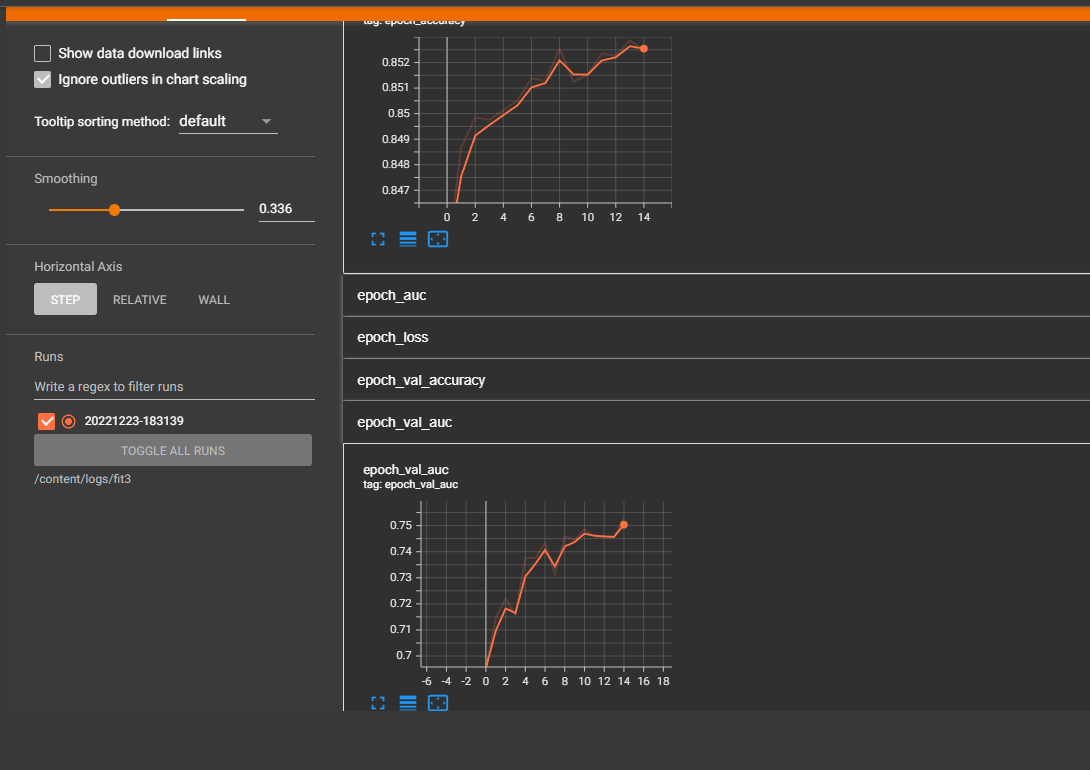

# We can able to achieve test auc of greater than 0.75 in the model_3

# Summary

In [1]:
# Please compare all your models using Prettytable library
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable


x = PrettyTable()
x.field_names = ["Features", "Model", "Epochs", "Train AUC", "CV AUC", "Test AUC"]
x.add_row(["Model 1 (Embedding Layer Encoding)", "LSTM+Dense", 50, 0.763, 0.751, 0.747])
x.add_row(["Model 2 (TFIDF based essay text + Embedding Layer Encoding)", "LSTM+Dense", 50, 0.816, 0.742, 0.742])
x.add_row(["Model 3 (Essay text + categorical feature OHE + numerical feature )", "LSTM+Conv1D+Dense", 50, 0.762, 0.752, 0.753])
print(x)

+---------------------------------------------------------------------+-------------------+--------+-----------+--------+----------+
|                               Features                              |       Model       | Epochs | Train AUC | CV AUC | Test AUC |
+---------------------------------------------------------------------+-------------------+--------+-----------+--------+----------+
|                  Model 1 (Embedding Layer Encoding)                 |     LSTM+Dense    |   50   |   0.763   | 0.751  |  0.747   |
|     Model 2 (TFIDF based essay text + Embedding Layer Encoding)     |     LSTM+Dense    |   50   |   0.816   | 0.742  |  0.742   |
| Model 3 (Essay text + categorical feature OHE + numerical feature ) | LSTM+Conv1D+Dense |   50   |   0.762   | 0.752  |  0.753   |
+---------------------------------------------------------------------+-------------------+--------+-----------+--------+----------+
